In [1]:
import sys,os
if not(os.path.isfile("train_nominal_000.h5")):
    if sys.platform=="darwin": #MAC OSX
        !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/train_nominal_000.h5.gz --output train_nominal_000.h5.gz
        !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/test_nominal_000.h5.gz --output test_nominal_000.h5.gz
    elif sys.platform == "linux" or sys.platform == "linux2":
        !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/train_nominal_000.h5.gz
        !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/test_nominal_000.h5.gz
    !gunzip -f train_nominal_000.h5.gz
    !gunzip -f test_nominal_000.h5.gz

In [2]:
import torch
from torch.utils.data import DataLoader, ConcatDataset

import matplotlib.pyplot as plt
import h5py
import numpy as np

In [3]:
class ATLASH5LowLevelDataset(torch.utils.data.Dataset):
    #copied from Kevin Grief https://gitlab.cern.ch/atlas/ATLAS-top-tagging-open-data/-/blob/master/utils.py?ref_type=heads#L21
    def transform(self,index,max_constits):
        # Pull data 
        pt = np.asarray([self.clus_pt[index][:max_constits]]) #NOTE this is changed w.r.t Kevin
        eta = np.asarray([self.clus_eta[index][:max_constits]])
        phi = np.asarray([self.clus_phi[index][:max_constits]])
        energy = np.asarray([self.clus_E[index][:max_constits]])

        # Find location of zero pt entries in each jet. This will be used as a
        # mask to re-zero out entries after all preprocessing steps
        mask = np.asarray(pt == 0).nonzero()

        ########################## Angular Coordinates #############################

        # 1. Center hardest constituent in eta/phi plane. First find eta and
        # phi shifts to be applied
        eta_shift = eta[:,0]
        phi_shift = phi[:,0]

        # Apply them using np.newaxis
        eta -= eta_shift[:,np.newaxis]
        phi -= phi_shift[:,np.newaxis]

        # Fix discontinuity in phi at +/- pi using np.where
        phi = np.where(phi > np.pi, phi - 2*np.pi, phi)
        phi = np.where(phi < -np.pi, phi + 2*np.pi, phi)

        # 2. Rotate such that 2nd hardest constituent sits on negative phi axis
        second_eta = eta[:,1]
        second_phi = phi[:,1]
        alpha = np.arctan2(second_phi, second_eta) + np.pi/2
        eta_rot = (eta * np.cos(alpha[:,np.newaxis]) +
                   phi * np.sin(alpha[:,np.newaxis]))
        phi_rot = (-eta * np.sin(alpha[:,np.newaxis]) +
                   phi * np.cos(alpha[:,np.newaxis]))
        eta = eta_rot
        phi = phi_rot

        # 3. If needed, reflect so 3rd hardest constituent is in positive eta
        third_eta = eta[:,2]
        parity = np.where(third_eta < 0, -1, 1)
        eta = (eta * parity[:,np.newaxis]).astype(np.float32)
        # Cast to float32 needed to keep numpy from turning eta to double precision

        # 4. Calculate R with pre-processed eta/phi
        radius = np.sqrt(eta ** 2 + phi ** 2)


        ############################# pT and Energy ################################

        # Take the logarithm, ignoring -infs which will be set to zero later
        log_pt = np.log(pt)
        log_energy = np.log(energy)

        # Sum pt and energy in each jet
        sum_pt = np.sum(pt, axis=1)
        sum_energy = np.sum(energy, axis=1)

        # Normalize pt and energy and again take logarithm
        lognorm_pt = np.log(pt / sum_pt[:,np.newaxis])
        lognorm_energy = np.log(energy / sum_energy[:,np.newaxis])

        ########################### Finalize and Return ############################

        # Reset all of the original zero entries to zero
        eta[mask] = 0
        phi[mask] = 0
        log_pt[mask] = 0
        log_energy[mask] = 0
        lognorm_pt[mask] = 0
        lognorm_energy[mask] = 0
        radius[mask] = 0

        # Stack along last axis
        features = [eta, phi, log_pt, log_energy,
                    lognorm_pt, lognorm_energy, radius]
        stacked_data = np.stack(features, axis=-1)

        return stacked_data
    
    def __init__(self, file_path, NConstituents=100, return_pt=False, transform=True):
        super(ATLASH5LowLevelDataset, self).__init__()
        h5_file = h5py.File(file_path , 'r')
        self.data=torch.tensor([])

        self.clus_E=h5_file['fjet_clus_E']
        self.clus_eta=h5_file['fjet_clus_eta']
        self.clus_phi=h5_file['fjet_clus_phi']
        self.clus_pt=h5_file['fjet_clus_pt']
        self.clus_tast=h5_file['fjet_clus_taste']

        self.pt = h5_file['fjet_pt']
        self.labels = h5_file['labels']

        if "training_weights" in h5_file:
            self.hasWeights=True
            self.weights = h5_file['training_weights']
        else:
            self.hasWeights=False

        self.return_pt = return_pt
        self.NConstituents = NConstituents
        self.doTransform = transform

    def __getitem__(self, index):
        if self.doTransform: 
            self.data=torch.squeeze(torch.tensor(self.transform(index,self.NConstituents)),dim=0)
            self.data=torch.swapaxes(self.data, 0, 1)
        else:
            self.data=torch.tensor([self.clus_eta[index][:self.NConstituents],self.clus_phi[index][:self.NConstituents],self.clus_pt[index][:self.NConstituents],self.clus_E[index][:self.NConstituents]])

        if self.return_pt:
            self.data=self.data,torch.tensor([self.pt[index]])

        if self.hasWeights:
            return self.data,torch.tensor(self.labels[index],dtype=torch.int64),torch.tensor(self.weights[index])
        else:
            return self.data,torch.tensor(self.labels[index],dtype=torch.int64),torch.tensor(1)

    def __len__(self):
        return len(self.labels)

In [4]:
def get_ATLAS_inputs(directory,network,batch_size=2**8,return_pt=False,transform=True):
    
    #Get list of input files
    training_list=[]
    testing_list=[]
    for file in sorted(os.listdir(directory)):
        if not ".h5" in file: continue
        if "train" in file:
            print("Using file %s for training"%(directory+"/"+file))
            training_list.append(directory+"/"+file)
        elif "test" in file:
            print("Using file %s for testing"%(directory+"/"+file))
            testing_list.append(directory+"/"+file)
    
    #concat them
    training_DSlist=[]
    testing_DSlist=[]
    if network!="HL":
        for file in training_list: training_DSlist.append(ATLASH5LowLevelDataset(file,return_pt=return_pt,transform=transform))
        for file in testing_list: testing_DSlist.append(ATLASH5LowLevelDataset(file,return_pt=return_pt,transform=transform))
    else:
        for file in training_list: training_DSlist.append(ATLASH5HighLevelDataset(file,return_pt=return_pt,transform=transform))
        for file in testing_list: testing_DSlist.append(ATLASH5HighLevelDataset(file,return_pt=return_pt,transform=transform))
    training_data = ConcatDataset(training_DSlist)
    testing_data = ConcatDataset(testing_DSlist)
    
    #load them into torch dataloaders 
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
    test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)
    
    #return
    return train_dataloader, test_dataloader

In [5]:
#Get dataloaders, function in utils.py
train_dataloader,test_dataloader=get_ATLAS_inputs("./","Transformer",batch_size=2**8,transform=False)

Using file .//test_nominal_000.h5 for testing
Using file .//train_nominal_000.h5 for training


In [6]:
#Quick debug on input shape
for x, y, z in train_dataloader:
    print(f"Shape of x: {x.shape}, {x.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(f"Shape of z: {z.shape} {z.dtype}")
    #print(x,y,z)
    break

/Users/les/venv/CometaTutorial/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)


Shape of x: torch.Size([256, 4, 100]), torch.float32
Shape of y: torch.Size([256]) torch.int64
Shape of z: torch.Size([256]) torch.float32


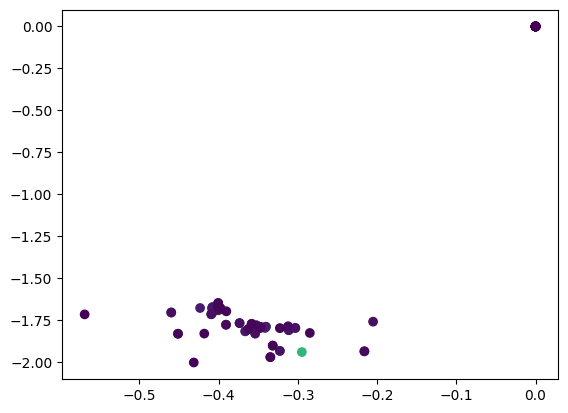

In [7]:
eta=x[0,0,:].flatten().numpy()
phi=x[0,1,:].flatten().numpy()
pt=x[0,2,:].flatten().numpy()
energy=x[0,3,:].flatten().numpy()

figure = plt.figure()
plt.scatter(eta,phi,c=pt)

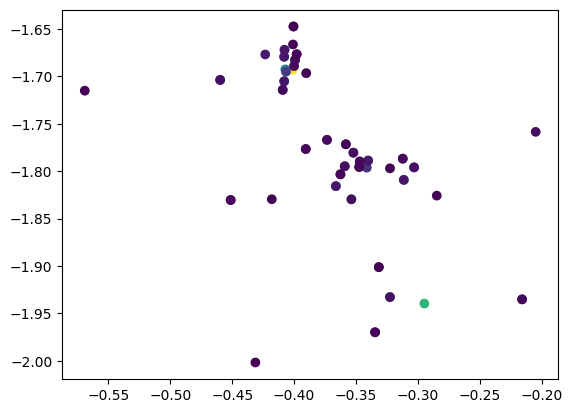

In [8]:
mask = np.asarray(pt > 0)
eta=eta[mask]
phi=phi[mask]
pt=pt[mask]
energy=energy[mask]

plt.scatter(eta,phi,c=pt)

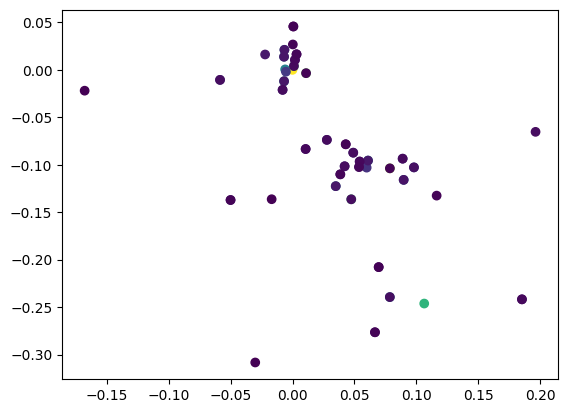

In [9]:
# 1. Center hardest constituent in eta/phi plane. First find eta and
# phi shifts to be applied
eta_shift = eta[0]
phi_shift = phi[0]

# Apply them using np.newaxis
eta -= eta_shift[np.newaxis]
phi -= phi_shift[np.newaxis]

# Fix discontinuity in phi at +/- pi using np.where
phi = np.where(phi > np.pi, phi - 2*np.pi, phi)
phi = np.where(phi < -np.pi, phi + 2*np.pi, phi)

plt.scatter(eta,phi,c=pt)

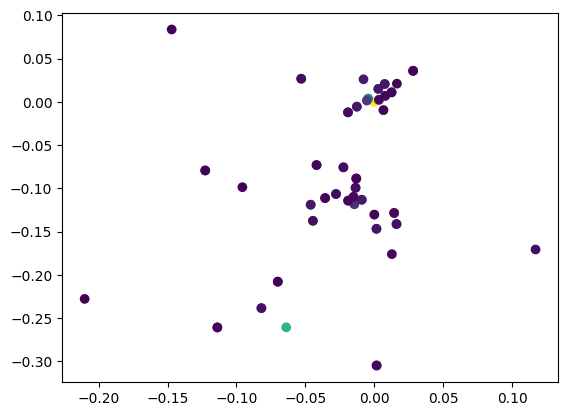

In [10]:
# 2. Rotate such that 2nd hardest constituent sits on negative phi axis
second_eta = eta[1]
second_phi = phi[1]
alpha = np.arctan2(second_phi, second_eta) + np.pi/2
eta_rot = (eta * np.cos(alpha[np.newaxis]) +
           phi * np.sin(alpha[np.newaxis]))
phi_rot = (-eta * np.sin(alpha[np.newaxis]) +
           phi * np.cos(alpha[np.newaxis]))
eta = eta_rot
phi = phi_rot

plt.scatter(eta,phi,c=pt)

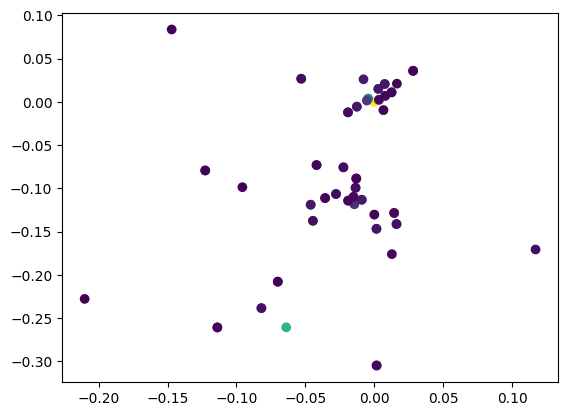

In [11]:
# 3. If needed, reflect so 3rd hardest constituent is in positive eta
third_eta = eta[2]
parity = np.where(third_eta < 0, -1, 1)
eta = (eta * parity[np.newaxis]).astype(np.float32)
# Cast to float32 needed to keep numpy from turning eta to double precision

plt.scatter(eta,phi,c=pt)